In [1]:
import sys
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# FOLDERNAME = 'ex3_302168687_200409159'
sys.path.append('/content/drive/MyDrive')
# sys.path.append('/content/drive/My Drive/{}/Q4'.format(FOLDERNAME))
%cd /content/drive/MyDrive
time_test=True
# %load_ext autoreload
# %autoreload 2

Mounted at /content/drive/
/content/drive/MyDrive


Imports

In [2]:
!pip install torch # ==1.7.0+cu101
!pip install torchaudio==0.7.0
!pip install torchvision==0.8.0
!pip install soundfile

     |████████████████████████████████| 7.6MB 6.8MB/s 
     |████████████████████████████████| 776.8MB 18kB/s 
ERROR: torchvision 0.8.2+cu101 has requirement torch==1.7.1, but you'll have torch 1.7.0 which is incompatible.
  Found existing installation: torch 1.7.1+cu101
    Uninstalling torch-1.7.1+cu101:
      Successfully uninstalled torch-1.7.1+cu101
     |████████████████████████████████| 11.8MB 266kB/s 
  Found existing installation: torchvision 0.8.2+cu101
    Uninstalling torchvision-0.8.2+cu101:
      Successfully uninstalled torchvision-0.8.2+cu101


In [3]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import datasets, models, transforms
import torchaudio

import os
import matplotlib
import pylab
import librosa
import numpy as np

import soundfile as sf

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

#!apt-get install sox libsox-dev libsox-fmt-all
#!pip install git+git://github.com/pytorch/audio
from IPython.display import Audio

from scipy.io import wavfile
from librosa.feature import mfcc
# Load the Pandas libraries with alias 'pd' 
import pandas as pd 

import os
import pandas as pd
import random

from pathlib import Path

/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


# Model architecture


In [4]:
class CnnAudioNet(nn.Module):
    def __init__(self,numClasses):
        super(CnnAudioNet,self).__init__()
        self.num_classes = numClasses
        self.fc_features = 128
        self.C1 = nn.Conv2d(1,32,3,padding=1)
        self.C11 = nn.Conv2d(32,32,3,padding=1)
        self.C2 = nn.Conv2d(32,64,3,padding=1)
        self.C22 = nn.Conv2d(64,64,3,padding=1)
        self.C3 = nn.Conv2d(64,128,3,padding=1)
        self.C33 = nn.Conv2d(128,128,3,padding=1)
        
        self.BN1 = nn.BatchNorm2d(32)
        self.BN11 = nn.BatchNorm2d(32)
        self.BN2 = nn.BatchNorm2d(64)
        self.BN22 = nn.BatchNorm2d(64)
        self.BN3 = nn.BatchNorm2d(128)
        self.BN33 = nn.BatchNorm2d(128)
        
        self.BNFC = nn.BatchNorm1d(self.fc_features)
        self.maxpool1 = nn.MaxPool2d(2,2)
        self.maxpool2 = nn.MaxPool2d((2,2),(2,2))
        self.softmax = nn.Softmax(dim=1)
        
        self.flatten = torch.nn.Flatten()

        # self.fc1 = nn.Linear(64*32*32,self.fc_features)
        self.fc1 = nn.Linear(512,self.fc_features)
        self.fc2 = nn.Linear(self.fc_features, 1) 
        
        self.dropout = nn.Dropout(0.35)

        self.BNout = nn.BatchNorm1d(1)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
    def forward(self,x,extra_feature):
        # add sequence of convolutional and max pooling layers
        x = self.maxpool1(F.relu(self.BN1(self.C1(x))))
        x = self.maxpool1(F.relu(self.BN11(self.C11(x)))) ##
        x = self.dropout(x)                                 ## @@
        x = self.maxpool1(F.relu(self.BN2(self.C2(x))))     
        x = self.maxpool1(F.relu(self.BN22(self.C22(x)))) ##
        # x = F.relu(self.BN3(self.C3(x)))                  ##
        # x = self.dropout(x)                                 ## @@  
        x = self.maxpool1(F.relu(self.BN3(self.C3(x))))     ## @@
        x = self.maxpool1(F.relu(self.BN33(self.C33(x)))) ##

        # flatten image input
        # x = x.view(-1,64*32*32)
        x = self.flatten(x)

        x = self.BNFC(self.fc1(x))
        x = self.dropout(x)
        if not time_test:
          x = torch.cat((x, extra_feature/240), 1) #normalize extra_feature
          x = self.fc2(x)
        else:
          # x = torch.cat((x, (extra_feature-2)/100), 1) #normalize extra_feature
          x = self.fc2(x)
          x = self.BNout(x)
          x = self.sigmoid(x) * 1440
          # x = (1+self.tanh(x))/2*1440
        #x = self.softmax(x) #already included in CrossEntropyLoss
        return x
        

Utility functions

In [5]:
def plotData(S, sr=44100, hop_length=512):
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
    plt.colorbar(format='%+2.0f dB');

def saveDataAsImage(S, save_path):
    pylab.axis('off') # no axis
    pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
    pylab.close()

def loadRec(wavPath):
    sound, sample_rate = torchaudio.load(wavPath)
    print("sample_rate", sample_rate)
    return Audio(data=sound[0,:],rate=sample_rate) # load a local WAV file

def saveModel(model, model_name, path):
    path = F"{path}/{model_name}.pt"
    torch.save(model.state_dict(), path)

def loadModel(model, model_name, path):
    path = F"{path}/{model_name}.pt"
    model.load_state_dict(torch.load(path))
    return model

@torch.no_grad()
def calculateTestLoss(model, criterion, test_generator):
    model.eval()
    test_loss = 0
    Label_all = []
    Output_all = []
    for dataBatch,target,timestamp in test_generator:
        dataBatch, target, timestamp = dataBatch.unsqueeze(1).float().cuda(), target.cuda(), timestamp.unsqueeze(1).cuda()
        output = model(dataBatch, timestamp)
        if not time_test:
          loss = criterion(output,torch.max(target.long(), 1)[1])
        else:
          # loss = min(criterion(output, target), criterion(output-1, target), criterion(output+1, target))
          loss = min(criterion(output, target), criterion(output-1440, target), criterion(output+1440, target))
        test_loss += loss.item()*dataBatch.size(0)
        Label_all.extend(target.tolist())
        Output_all.extend(output.tolist())

    x = np.abs(np.array(Label_all) - np.array(Output_all))
    y = 1440 - np.abs(np.array(Label_all) - np.array(Output_all))
    accuracy = (np.minimum(x,y)<=240).sum() / len(Label_all)
    # y = 1 - np.abs(np.array(Label_all) - np.array(Output_all))
    # accuracy = (np.minimum(x,y)<=(180/1440)).sum() / len(Label_all)

    return test_loss/len(test_generator), accuracy

Dataset

In [6]:
class Dataset(data.Dataset):
    def __init__(self, fileNames, locations, dataPath1, dataPath2, numClasses):
        'Initialization'

        self.locations = locations
        self.file_names = fileNames
        self.data_path1= dataPath1
        self.data_path2= dataPath2
        self.num_classes = numClasses
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.file_names)

    def __getitem__(self, index):
        'Generates one sample of data'
        file_name = self.file_names[index]
        location = self.locations[index]
        try:
          file = os.path.join(self.data_path1, str(location), str(file_name))
          Im = torch.load(file)
        except:
          file = os.path.join(self.data_path2, str(location), str(file_name))
          Im = torch.load(file)
        label_out = np.zeros(self.num_classes)
        label_out = torch.from_numpy(label_out).float()
        timestamp = file_name.split("_", 1)[1]
        timestamp = int(timestamp.split(".", 1)[0])/1000 # quantization of 30-minutes
        timestamp = torch.tensor(timestamp, dtype=torch.float32)
        #print(timestamp, Im.shape, label)
        if not time_test:
          label = location
          label_out[label-2] = 1
          extra_feature = timestamp
        else:
          label = (int(file_name[-9:-7])*60 + int(file_name[-7:-5])) # /1440
          label_out[0] = label
          extra_feature = location

        return Im, label_out,extra_feature

Select criterion and optimizer and load model

In [7]:
train_on_gpu=torch.cuda.is_available()
if time_test: 
  num_classes = 1
else:
  num_classes = 10
model = CnnAudioNet(num_classes)
model_name= "MonoCnnAudioNet"
if(train_on_gpu): 
    model.cuda()
print(model)
#pos_weight = torch.ones([num_classes]).cuda() * num_classes
#criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) 

CnnAudioNet(
  (C1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C22): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C33): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BN1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN22): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN33): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

Load dataset

In [8]:
spots_to_train = range(2,12)

random.seed(3)

# TODO: seperate paths for train/test

path = '/content/drive/MyDrive/Project/Dataset'
path_csv = '/content/drive/MyDrive/project_new/copy/DataSet'
test_path_csv = '/content/drive/MyDrive/project_new/copy/TestSet'
test_path = '/content/drive/MyDrive/Project/Testset'

#Load train data
labels = pd.read_csv(os.path.join(path_csv, "labels.csv"))
test_labels = pd.read_csv(os.path.join(test_path_csv, "labels.csv"))
labels = pd.concat([labels, test_labels])

sample_indexes = [label in spots_to_train for label in labels['label']]
labels = labels[sample_indexes]

n_samples = len(labels)
train_len = int(n_samples * 0.9)
valid_len = int(n_samples * 0.05)
test_len  = n_samples - train_len - valid_len

total_list = list(range(n_samples))
train_list = random.sample(total_list, train_len)
total_list = list(set(total_list)^set(train_list))
valid_list = random.sample(total_list, valid_len)
total_list = list(set(total_list)^set(valid_list))
test_list = random.sample(total_list, test_len)

test_data = labels.iloc[test_list]
train_data = labels.iloc[train_list]
valid_data = labels.iloc[valid_list]

path = os.path.join(path, "Mono")
test_path = os.path.join(test_path, "Mono")

training_set = Dataset(train_data["filename"].tolist(), train_data["label"].tolist(), path, test_path, num_classes)
batch_size = 32
train_params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 6}
training_generator = data.DataLoader(training_set, **train_params)
#Load validation data
valid_set = Dataset(valid_data["filename"].tolist(), valid_data["label"].tolist(), path,  test_path, num_classes)
batch_size = 32
valid_params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 6}
valid_generator = data.DataLoader(valid_set, **valid_params)
#Load Test data
test_set = Dataset(test_data["filename"].tolist(), test_data["label"].tolist(), path,  test_path, num_classes)
batch_size = 32
test_params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 6}
test_generator = data.DataLoader(test_set, **test_params)

print("Training set contains " + str(train_len) + " samples")
print("Validation set contains " + str(valid_len) + " samples")
print("Test set contains " + str(test_len) + " samples")

Training set contains 40500 samples
Validation set contains 2250 samples
Test set contains 2250 samples


# Train & test

In [9]:
%pdb off

import time
# !pip install tqdm
from tqdm.auto import tqdm

epoch_num = 74 # epoch to start from (if >0 load checkpoint)
n_epochs = 0 # number of epochs for training

lr_decay = 0.99
lr = 1e-3 * (lr_decay)**epoch_num
lr_decay_step = 1

wd = 1e-6
betas=(0.9, 0.999)

train_on_gpu=torch.cuda.is_available()
if time_test: 
  num_classes = 1
else:
  num_classes = 10
model = CnnAudioNet(num_classes)
model_name= "MonoCnnAudioNet"
if(train_on_gpu): 
  model.cuda()

checkpoint_path = "/content/drive/MyDrive/project_new/copy/weights/Mono/spot_" + '_'.join(str(spot) for spot in spots_to_train)
Path(checkpoint_path).mkdir(parents=True, exist_ok=True)

if epoch_num > 0:
  model = loadModel(model, model_name + "_" + str(epoch_num), checkpoint_path)

print("Starting from epoch", epoch_num+1)

start_time = time.time()
#Warnings.filterwarnings('ignore')

if not time_test: 
  criterion = nn.CrossEntropyLoss()
else:
  criterion = nn.MSELoss()

optimizer     = optim.Adam(params=model.parameters(), lr=lr, betas=betas, weight_decay=wd) 
lr_scheduler  = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay)

valid_loss_min = np.Inf # track change in validation loss
print("Start training:")
idx = 0 
for epoch in range(epoch_num+1, epoch_num+n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    TotMSE = 0 
    TotEl = 0
    
    ###################
    # train the model #
    ###################
    
    model.train()
    Label_all = []
    Output_all = []

    per_n_batch_output = []
    per_n_batch_labels = []

    for batch_idx, (dataBatch, target, extra_feature) in tqdm(enumerate(training_generator), total=len(training_generator), leave=True):
    # for batch_idx, (dataBatch, target, extra_feature) in enumerate(training_generator):  
    
        #print("dataBatch.shape", dataBatch.shape)
      idx+=1
        # move tensors to GPU if CUDA is available
      if train_on_gpu:
          dataBatch, target, extra_feature = dataBatch.unsqueeze(1).cuda(), target.cuda(), extra_feature.unsqueeze(1).cuda()#dataBatch.unsqueeze(2).float().cuda(), target.cuda()

      # clear the gradients of all optimized variables
      optimizer.zero_grad()
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(dataBatch,extra_feature)
      # calculate the batch loss
      if not time_test:
        loss = criterion(output,torch.max(target.long(), 1)[1])
      else:
        loss = min(criterion(output, target), criterion(output-1440, target), criterion(output+1440, target))
        # loss = min(criterion(output, target), criterion(output-1, target), criterion(output+1, target))
      # import pdb; pdb.set_trace()
      # backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # perform a single optimization step (parameter update)
      optimizer.step()
      # update training loss
      train_loss += loss.item()*dataBatch.size(0)
      
      Label_all.extend(target.tolist())
      Output_all.extend(output.tolist())

      per_n_batch_labels.extend(output.tolist())
      per_n_batch_output.extend(target.tolist())

      if not batch_idx%100:
        x = np.abs(np.array(per_n_batch_labels) - np.array(per_n_batch_output))
        y = 1440 - np.abs(np.array(per_n_batch_labels) - np.array(per_n_batch_output))
        # temp_train_acc = (np.minimum(x,y)<=(180/1440)).sum() / len(Label_all)
        temp_train_acc = (np.minimum(x,y)<=240).sum() / len(per_n_batch_labels)
        print(temp_train_acc)
        
        per_n_batch_output = []
        per_n_batch_labels = []

        # lr_scheduler.step()

    # perform LR decay step
    lr_scheduler.step()

    x = np.abs(np.array(Label_all) - np.array(Output_all))
    y = 1440 - np.abs(np.array(Label_all) - np.array(Output_all))
    train_acc = (np.minimum(x,y)<=240).sum() / len(Label_all)
    # y = 1 - np.abs(np.array(Label_all) - np.array(Output_all))
    # train_acc = (np.minimum(x,y)<=(180/1440)).sum() / len(Label_all)
    train_loss = train_loss / len(training_generator)
    valid_loss,valid_acc = calculateTestLoss(model, criterion, valid_generator)
    test_loss, test_acc = calculateTestLoss(model, criterion, test_generator)
    print('Epoch: {} \tTrain Loss: {:.6f}\t Validation Loss: {:.6f}\t Test Loss: {:6f}'.format(epoch, train_loss, valid_loss, test_loss))
    print('Epoch: {} \tTrain Acc: {:.6f}\t Validation Acc: {:.6f}\t Test Acc: {:6f}'.format(epoch, train_acc, valid_acc, test_acc))

    saveModel(model,model_name + "_" + str(epoch),checkpoint_path)

print(F"\nLR = {optimizer.param_groups[0]['lr']}\n")


Automatic pdb calling has been turned OFF
Starting from epoch 75
Start training:

LR = 0.00047534004200570695



Evaluate model on validation set

In [11]:
epoch_num = 74
checkpoint_path = "/content/drive/MyDrive/project_new/copy/weights/Mono/spot_" + '_'.join(str(spot) for spot in spots_to_train)
model = loadModel(model, model_name + "_" + str(epoch_num), checkpoint_path)
model.eval()
SoftM = torch.nn.Softmax()
Label_all = []
Output_all = []
with torch.no_grad():                   # operations inside don't track history

    for dataBatch,label,timestamp in valid_generator:
        if train_on_gpu:
            dataBatch,label,timestamp = dataBatch.unsqueeze(1).float().cuda(), label.cuda(), timestamp.unsqueeze(1).cuda()#dataBatch.unsqueeze(1).float().cuda(), label.cuda()
  
        output = model(dataBatch,timestamp)
        
        
        Label_all.extend(label.tolist())
        Output_all.extend(output.tolist())

x = np.abs(np.array(Label_all) - np.array(Output_all))
y = 1440 - np.abs(np.array(Label_all) - np.array(Output_all))
accuracy = (np.minimum(x,y)<=240).sum() / len(Label_all)
print('Validation accuracy: {}%'.format(accuracy * 100))

Validation accuracy: 90.57777777777778%


Evaluate model on test set

In [17]:
epoch_num = 74
checkpoint_path = "/content/drive/MyDrive/project_new/copy/weights/Mono/spot_" + '_'.join(str(spot) for spot in spots_to_train)
model = loadModel(model, model_name + "_" + str(epoch_num), checkpoint_path)
model.eval()
Label_all = []
Output_all = []
with torch.no_grad():                   # operations inside don't track history

    for dataBatch,label,timestamp in test_generator:
        if train_on_gpu:
            dataBatch,label,timestamp = dataBatch.unsqueeze(1).float().cuda(), label.cuda(), timestamp.unsqueeze(1).cuda()#dataBatch.unsqueeze(1).float().cuda(), label.cuda()
          
        output = model(dataBatch,timestamp)
        
        
        Label_all.extend(label.tolist())
        Output_all.extend(output.tolist())

x = np.abs(np.array(Label_all) - np.array(Output_all))
y = 1440 - np.abs(np.array(Label_all) - np.array(Output_all))
accuracy = (np.minimum(x,y)<=240).sum() / len(Label_all)
print('Test accuracy: {}%'.format(accuracy * 100))

Test accuracy: 87.86666666666667%


Evaluate model on training

In [ ]:
epoch_num = 74
checkpoint_path = "/content/drive/MyDrive/project_new/copy/weights/Mono/spot_" + '_'.join(str(spot) for spot in spots_to_train)
model = loadModel(model, model_name + "_" + str(epoch_num), checkpoint_path)
model.eval()
Label_all = []
Output_all = []
with torch.no_grad():                   # operations inside don't track history

    for dataBatch,label,timestamp in training_generator:
        if train_on_gpu:
            dataBatch,label,timestamp = dataBatch.unsqueeze(1).float().cuda(), label.cuda(), timestamp.unsqueeze(1).cuda()#dataBatch.unsqueeze(1).float().cuda(), label.cuda()
        output = model(dataBatch, timestamp)
        
        Label_all.extend(label.tolist())
        Output_all.extend(output.tolist())
        
x = np.abs(np.array(Label_all) - np.array(Output_all))
y = 1440 - np.abs(np.array(Label_all) - np.array(Output_all))
accuracy = (np.minimum(x,y)<=240).sum() / len(Label_all)
print('Train accuracy: {}%'.format(accuracy * 100))

Train accuracy: 94.66944444444444%


Plot confusion matrix

In [13]:
@torch.no_grad()
def get_all_preds(model, loader):
    model.eval()
    all_preds = torch.tensor([])
    all_targets = torch.tensor([])
    for batch in loader:
        images, labels, timestamp = batch
        images, labels, timestamp = images.unsqueeze(1).float().cuda(), labels.cuda(), timestamp.unsqueeze(1).cuda()#images.unsqueeze(1).float().cuda(), labels.cuda()
        if time_test:
          preds = model(images, timestamp)
          preds = preds.cpu().numpy()
          preds = preds//60
          labels = labels//60
          labels = labels.cpu().numpy()
        else:
          preds = torch.nn.functional.softmax(preds)
        all_preds = torch.cat(
            (all_preds,  torch.from_numpy(preds))
            ,dim=0
        )
        all_targets = torch.cat(
            (all_targets,  torch.from_numpy(labels))
            ,dim=0
        )
    return all_preds.cpu(), all_targets.cpu()

def confusion_matrix(real_targets, train_preds):
    stacked = torch.stack((real_targets,train_preds),dim=1)
    cmt = torch.zeros(24,24, dtype=torch.int64)
    for p in stacked:
        tl, pl = p.tolist()
        cmt[tl, pl] = cmt[tl, pl] + 1
    
    return cmt


import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.type(torch.FloatTensor) / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

Normalized confusion matrix


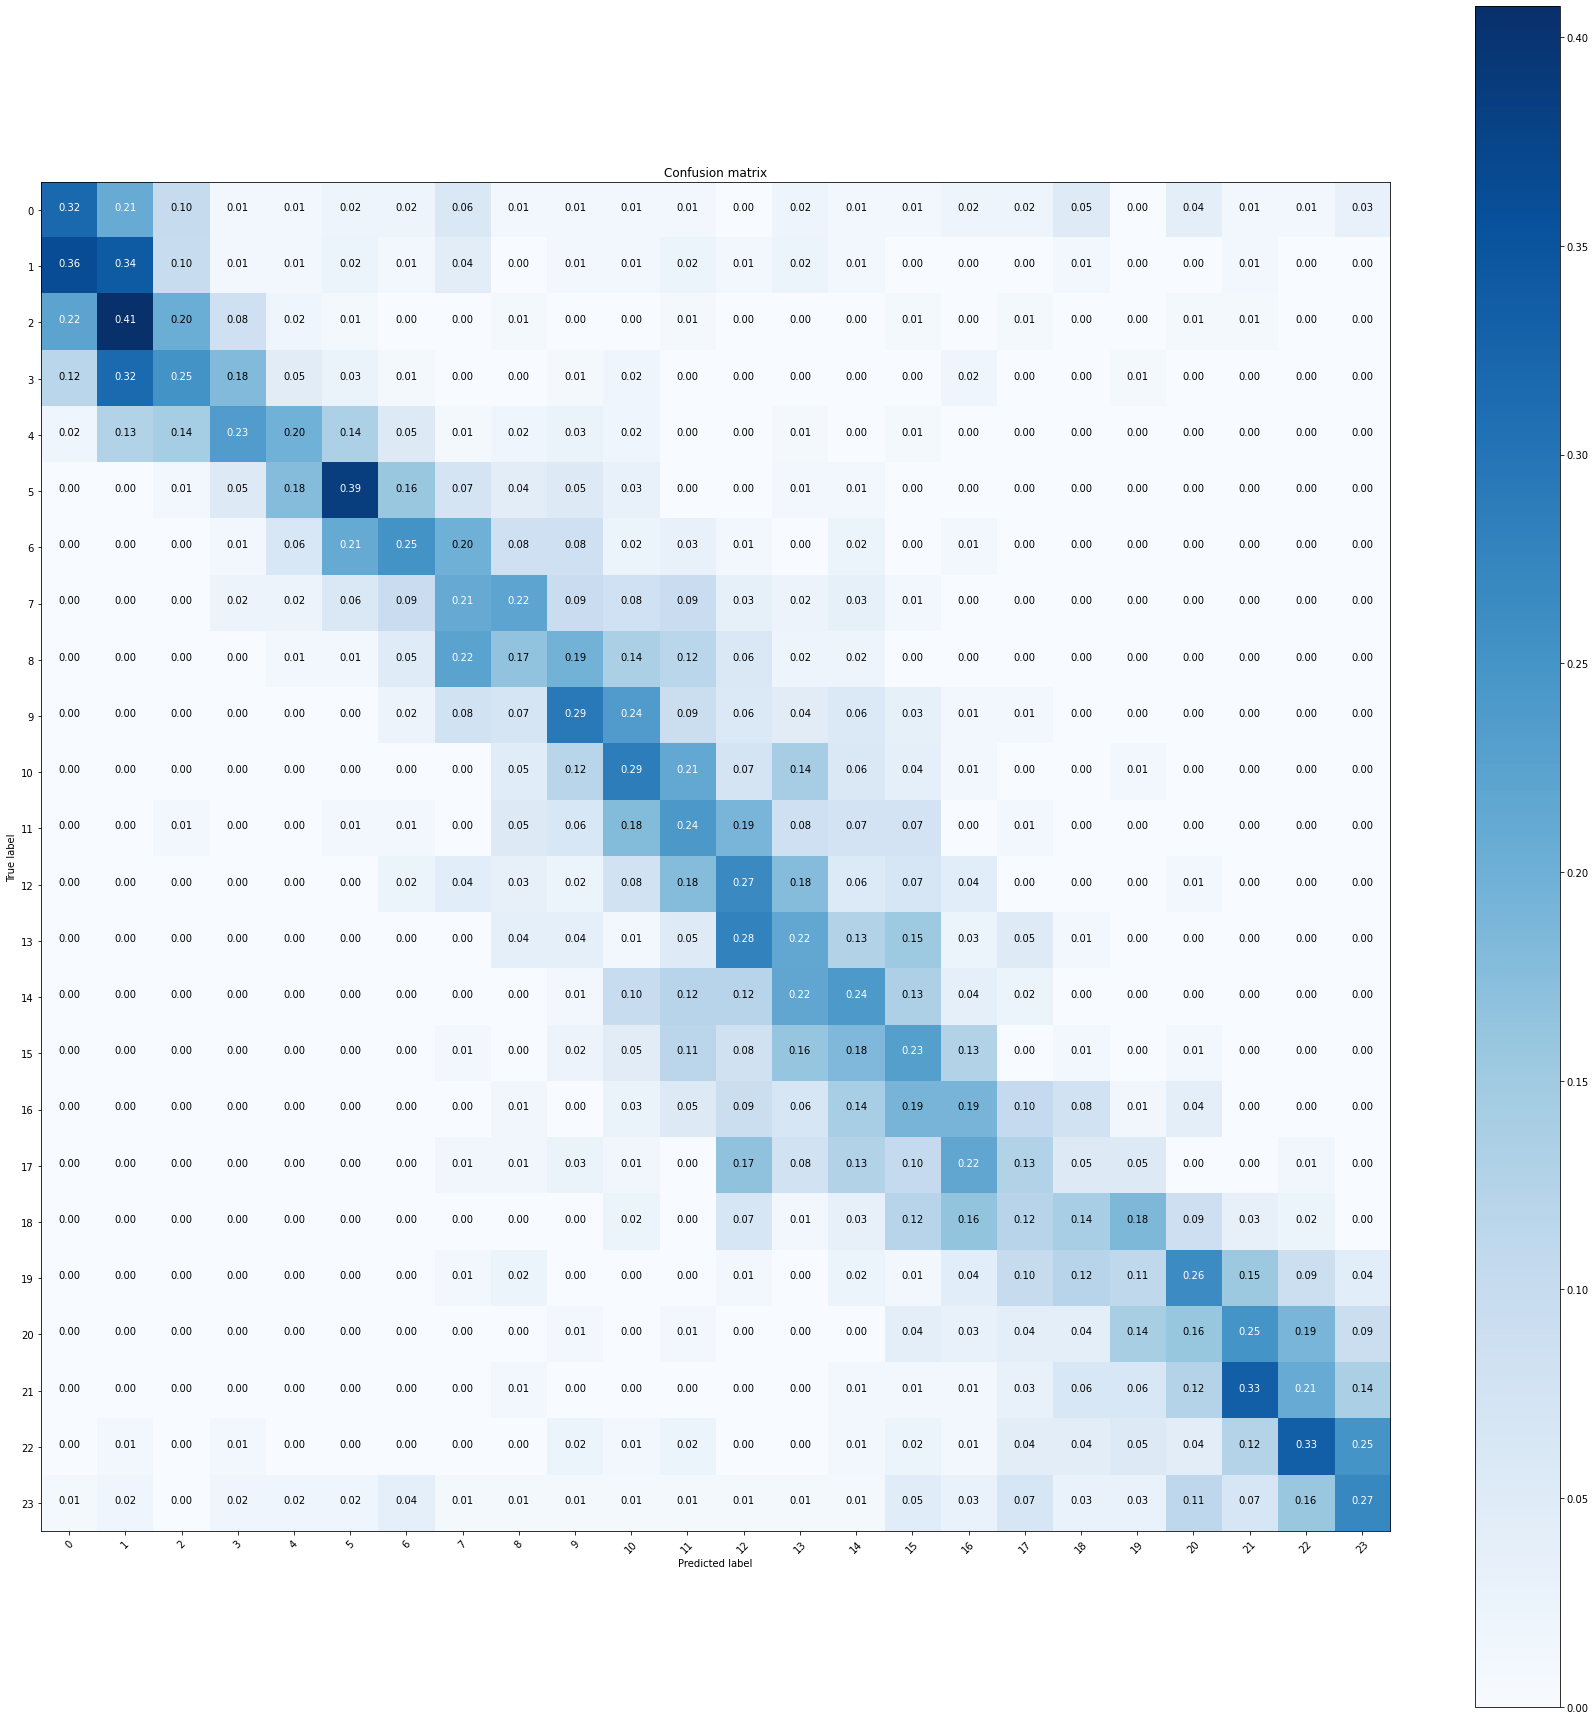

In [14]:
import matplotlib.pyplot as plt

#from sklearn.metrics import confusion_matrix

with torch.no_grad():
    train_preds, real_targets = get_all_preds(model, test_generator)

cm = confusion_matrix(real_targets, train_preds)
plt.figure(figsize=(24,24))
classes = [str(i) for i in range(24)]
plot_confusion_matrix(cm, classes)
    

Save model weights for ensemble

In [15]:
with torch.no_grad():
    train_preds, real_targets = get_all_preds(model, valid_generator)

cm = confusion_matrix(real_targets, train_preds)
cm = cm.type(torch.FloatTensor) / cm.sum(axis=1)[:, np.newaxis]
model_weights = torch.zeros(24)
for i in range(0,24):
    model_weights[i] = cm[i][i]
model_acc = torch.sum(model_weights) / 24

print("model accuracy is", model_acc)
print("model weights are ", model_weights)
torch.save(model_acc, "/content/drive/MyDrive/project_new/copy/Models/mono_accuracy.pt")
torch.save(model_weights, "/content/drive/MyDrive/project_new/copy/Models/mono_weights.pt")


model accuracy is tensor(0.2358)
model weights are  tensor([0.3600, 0.3723, 0.1818, 0.2115, 0.2569, 0.3434, 0.2292, 0.1818, 0.1789,
        0.2159, 0.2065, 0.2414, 0.2073, 0.2056, 0.2987, 0.2278, 0.2118, 0.1494,
        0.1684, 0.1947, 0.1414, 0.2317, 0.3500, 0.2917])
